In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    domain = list(domain)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    domain = list(domain)
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)

    counts = {v: 0 for v in domain}
    for r in reports:
        if r in counts:
            counts[r] += 1
        else:
            raise ValueError(f"Reported value '{r}' not in domain")

    return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

def random_split_perturb(df, epsilon):
    """
    Each user perturbs all attributes using equal budget split.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    perturbed = []

    for _, row in df.iterrows():
        noisy_row = [
            grr_perturb(row[col], df[col].unique(), eps_attr)
            for col in df.columns
        ]
        perturbed.append(noisy_row)
    
    return perturbed

def random_split_estimate(reports, df, epsilon):
    """
    Estimate frequencies for each attribute independently.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    reports = np.array(reports)
    estimates = {}

    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        col_reports = reports[:, i]
        estimates[col] = grr_estimate_frequencies(col_reports, domain, eps_attr)

    return estimates

def rs_fd_perturb(df, domains, epsilon):
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    cols = list(domains.keys())
    
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        output = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                output[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                output[col] = np.random.choice(domain)
        privatized.append(output)
    
    return pd.DataFrame(privatized, index=df.index)


def rs_fd_estimate(perturbed_df, domains, epsilon):
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()

        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        estimates[col] = est

    return estimates


def rs_rfd_perturb(df, domains, priors, epsilon):
    """
    RS+RFD[GRR] client-side perturbation.

    Args:
        df       : DataFrame of true user data.
        domains  : dict mapping each attribute to its domain.
        priors   : dict of prior distributions (same structure as output of get_true_frequencies).
        epsilon  : privacy budget.

    Returns:
        DataFrame of privatized data.
    """
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    cols = list(df.columns)
    epsilon_prime = epsilon
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)  # index of sampled attribute
        y = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                # Sanitize sampled attribute with GRR
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # Fake value sampled from prior
                prior_probs = [priors[col].get(v, 0.0) for v in domain]
                prior_probs = np.array(prior_probs)
                prior_probs /= prior_probs.sum()  # ensure normalization
                y[col] = np.random.choice(domain, p=prior_probs)
        privatized.append(y)

    return pd.DataFrame(privatized, index=df.index)
def rs_rfd_estimate(perturbed_df, domains, priors, epsilon):
    """
    RS+RFD[GRR] server-side frequency estimator.

    Args:
        perturbed_df : output of rs_rfd_perturb.
        domains      : dict of attribute → domain list.
        priors       : dict of attribute → {value: prior prob}.
        epsilon      : same ε used in perturbation.

    Returns:
        dict of attribute → {value: estimated frequency}.
    """
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        exp_eps = np.exp(epsilon_prime)
        p = exp_eps / (exp_eps + kj - 1)
        q = (1 - p) / (kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_vi = counts.get(v, 0)
            f_prior = priors[col].get(v, 0.0)
            bias = q + (d - 1) * f_prior
            numerator = d * C_vi - n * bias
            denominator = n * (p - q)
            est[v] = numerator / denominator
        estimates[col] = est

    return estimates




# --- p_y Optimization Function ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
    return float(np.clip(p_star, 0.0, 1.0))

# --- Phase 1 SPL ---
def corr_rr_phase1_spl(df, epsilon, frac=0.1):
    n = len(df)
    m = int(frac * n)
    df_A = df.iloc[:m]
    eps_split = epsilon / df.shape[1]
    
    reports = []
    for _, row in df_A.iterrows():
        reports.append([
            grr_perturb(row[col], df[col].unique(), eps_split)
            for col in df.columns
        ])
    reports = np.array(reports)
    
    est = {}
    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        est[col] = grr_estimate_frequencies(reports[:, i], domain, eps_split)
    return est, df.iloc[m:]

# --- Phase 2 Corr-RR Perturbation ---
def corr_rr_phase2_perturb(df, epsilon, f_hat_phase1, domain_map, p_y_table):
    d = len(df.columns)
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        perturbed = {}
        for i, col in enumerate(df.columns):
            domain = domain_map[col]
            if i == j:
                perturbed[col] = grr_perturb(row[col], domain, epsilon)
            else:
                pair = (df.columns[j], col)
                py = p_y_table.get(pair, 0.5)
                if np.random.rand() < py:
                    perturbed[col] = row[col]
                else:
                    perturbed[col] = np.random.choice([v for v in domain if v != row[col]])
        privatized.append(perturbed)
    return pd.DataFrame(privatized, index=df.index)

# --- Corr-RR Estimator (using standard GRR) ---
def corr_rr_estimate(perturbed_df, domains, epsilon):
    estimates = {}
    n, d = perturbed_df.shape
    for col, domain in domains.items():
        reports = perturbed_df[col].tolist()
        estimates[col] = grr_estimate_frequencies(reports, domain, epsilon)
    return estimates

# --- Weighted Merge of Phase Estimates ---
def combine_phase_estimates(est_A, est_B, m, n_minus_m):
    combined = {}
    for col in est_A:
        combined[col] = {}
        for v in est_A[col]:
            combined[col][v] = (m * est_A[col][v] + n_minus_m * est_B[col][v]) / (m + n_minus_m)
    return combined
# --- True Frequency Utility ---
def get_true_frequencies(df, columns):
    freq_dict = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq_dict[col] = counts.to_dict()
    return freq_dict

# def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
#     if seed is not None:
#         np.random.seed(seed)

#     domain = list(domain)
#     domain_set = {x: [d for d in domain if d != x] for x in domain}
#     df = pd.DataFrame()

#     # Add correlated attributes
#     if correlations:
#         for attr1, attr2, p_same in correlations:
#             X1 = np.random.choice(domain, size=n)
#             mask = np.random.rand(n) < p_same
#             X2 = np.where(mask, X1, [np.random.choice(domain_set[v]) for v in X1])
#             df[attr1] = X1
#             df[attr2] = X2

#     # Decide which attributes to include
#     if total_attributes is not None:
#         all_attrs = [f'X{i+1}' for i in range(total_attributes)]
#     else:
#         all_attrs = list(df.columns)

#     for attr in all_attrs:
#         if attr not in df.columns:
#             df[attr] = np.random.choice(domain, size=n)

#     return df

# domain = [0, 1, 2, 3]
# correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]

# df = correlated_data_generator(domain, n=1000, correlations=correlations, total_attributes=2, seed=42)
# print(df.columns)  # ['X1', 'X2']
# print(df.head())

In [3]:
def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    """
    Generate a dataset with arbitrary chain correlations:
      correlations = [('X1','X2',0.93), ('X2','X3',0.93), ...]
    total_attributes: total number of attributes (for uncorrelated attributes)
    """
    if seed is not None:
        np.random.seed(seed)
    domain = list(domain)
    df = pd.DataFrame()
    generated = set()

    # Parse unique attribute names
    if correlations:
        attrs = set()
        for a, b, _ in correlations:
            attrs.add(a)
            attrs.add(b)
        attrs = sorted(list(attrs), key=lambda x: int(x[1:]) if x[1:].isdigit() else x)
    else:
        attrs = []

    # Step 1: Generate the first attribute in the chain randomly
    if correlations:
        first_attr = correlations[0][0]
        df[first_attr] = np.random.choice(domain, size=n)
        generated.add(first_attr)
        # Step 2: Chain-generate each next attribute
        for (parent, child, p_same) in correlations:
            if child not in generated:
                parent_vals = df[parent]
                mask = np.random.rand(n) < p_same
                child_vals = np.where(mask, parent_vals,
                                     np.random.choice([v for v in domain if v != parent_vals[0]], size=n))
                # Slight bug: each user should be compared to their own parent's value
                # Fix:
                child_vals = np.empty(n, dtype=type(domain[0]))
                for i in range(n):
                    if mask[i]:
                        child_vals[i] = parent_vals.iloc[i]
                    else:
                        child_vals[i] = np.random.choice([v for v in domain if v != parent_vals.iloc[i]])
                df[child] = child_vals
                generated.add(child)
    # Step 3: Add any extra attributes as iid random
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)
    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)
    return df


In [4]:
import matplotlib as mpl

# --- set global font to Times New Roman ---
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,            # switch to True if you have a TeX installation
    'font.size': 16,                 # fallback for general text
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 20,
})

DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.960 (specified: 0.95)
Empirical P[X3 == X2]: 0.900 (specified: 0.9)
Empirical P[X4 == X3]: 0.770 (specified: 0.85)
Empirical P[X5 == X4]: 0.900 (specified: 0.9)
Empirical P[X6 == X5]: 0.940 (specified: 0.95)

Pearson correlations:
           X1        X2        X3        X4        X5        X6
X1  1.000000  0.968541  0.832938  0.657927  0.545013  0.530919
X2  0.968541  1.000000  0.861999  0.677001  0.562766  0.549103
X3  0.832938  0.861999  1.000000  0.835547  0.694079  0.675006
X4  0.657927  0.677001  0.835547  1.000000  0.892129  0.812314
X5  0.545013  0.562766  0.694079  0.892129  1.000000  0.877866
X6  0.530919  0.549103  0.675006  0.812314  0.877866  1.000000


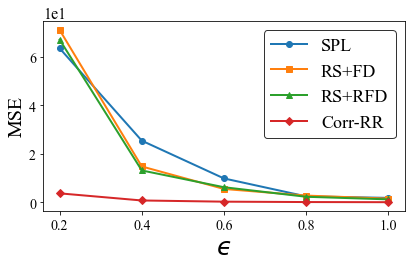

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.95), ('X2', 'X3', 0.90), ('X3', 'X4', 0.85), ('X4', 'X5', 0.90), ('X5', 'X6', 0.95)]
epsilons = [0.2, 0.4, 0.6, 0.8, 1.0]
n = 100
m = 0.05
R = 1  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns)-1):
    col1 = columns[i]
    col2 = columns[i+1]
    specified = [c[2] for c in correlations if c[0]==col1 and c[1]==col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Prepare rest for each run (use same df, perturbation is random)
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))

for run in range(R):
    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []

    for eps in epsilons:
        # SPL
        pert_spl = random_split_perturb(df, eps)
        est_spl  = random_split_estimate(pert_spl, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, eps)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + RFD
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
        n_A = int(m * len(df))
        n_B = len(df_B)
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, eps)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr.append(np.mean([
            np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

    all_spl[run, :]    = mse_spl
    all_rsfd[run, :]   = mse_rsfd
    all_rsrfd[run, :]  = mse_rsrfd
    all_corrrr[run, :] = mse_corrrr

# (Rest of your plotting code remains unchanged)
# compute the average MSE across runs
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)

# --- Plot only the mean curves ---
plt.figure(figsize=(6, 4))


# save to SVG:

plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
#plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()

# Create a dataframe for mean MSEs at each epsilon for each method
results_df = pd.DataFrame({
    'epsilon': epsilons,
    'SPL': mean_spl,
    'RS+FD': mean_rsfd,
    'RS+RFD': mean_rsrfd,
    'Corr-RR': mean_corrrr
})

#results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_10k_phase_05_attribute_6_cor_vary.xlsx', index=False)
#plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_10k_phase_05_attribute_6_cor_vary.svg', format="svg")


plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.951 (specified: 0.95)

Pearson correlations:
          X1       X2
X1  1.00000  0.94613
X2  0.94613  1.00000


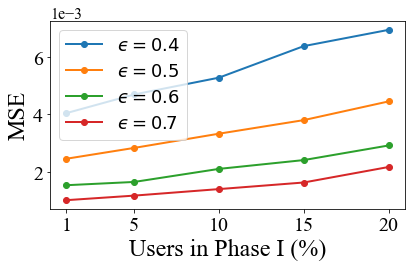

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.95)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [0.01, 0.05, 0.10,  0.15, 0.20]  # Phase I user fractions (m)
n = 10000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_10k__eps_phase1_corr_95.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_10k__eps_phase1_corr_95.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.801 (specified: 0.8)

Pearson correlations:
           X1        X2
X1  1.000000  0.776599
X2  0.776599  1.000000


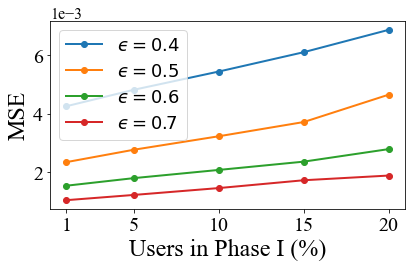

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.80)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [0.01, 0.05, 0.10,  0.15, 0.20]  # Phase I user fractions (m)
n = 10000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_10k__eps_phase1_corr_80.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_10k__eps_phase1_corr_80.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.701 (specified: 0.7)

Pearson correlations:
           X1        X2
X1  1.000000  0.666645
X2  0.666645  1.000000


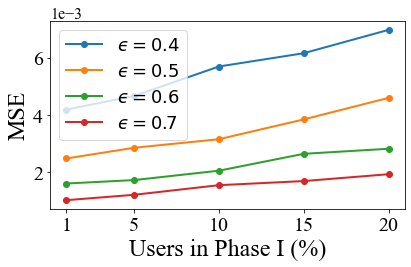

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.70)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [0.01, 0.05, 0.10,  0.15, 0.20]  # Phase I user fractions (m)
n = 10000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_10k__eps_phase1_corr_70.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_10k__eps_phase1_corr_70.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.500 (specified: 0.5)

Pearson correlations:
           X1        X2
X1  1.000000  0.444856
X2  0.444856  1.000000


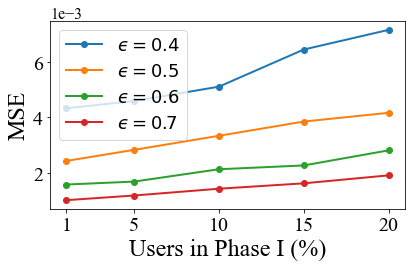

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.50)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [0.01, 0.05, 0.10,  0.15, 0.20]  # Phase I user fractions (m)
n = 10000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_10k__eps_phase1_corr_50.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_10k__eps_phase1_corr_50.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.489 (specified: 0.5)
Empirical P[X3 == X2]: 0.508 (specified: 0.5)
Empirical P[X4 == X3]: 0.506 (specified: 0.5)

Pearson correlations:
           X1        X2        X3        X4
X1  1.000000  0.412019  0.217207  0.097098
X2  0.412019  1.000000  0.460415  0.203880
X3  0.217207  0.460415  1.000000  0.418680
X4  0.097098  0.203880  0.418680  1.000000


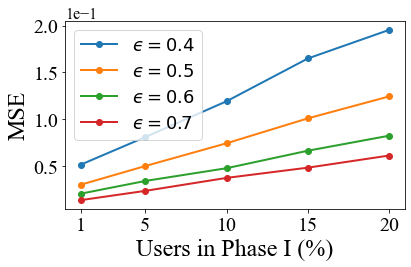

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.50), ('X2', 'X3', 0.50), ('X3', 'X4', 0.50)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [ 0.01, 0.05, 0.10, 0.15, 0.20]  # Phase I user fractions (m)
n = 1000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_1k__eps_phase1_corr_50_4attr.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_1k__eps_phase1_corr_50_4attr.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.500 (specified: 0.5)
Empirical P[X3 == X2]: 0.487 (specified: 0.5)
Empirical P[X4 == X3]: 0.509 (specified: 0.5)

Pearson correlations:
           X1        X2        X3        X4
X1  1.000000  0.451638  0.185656  0.090609
X2  0.451638  1.000000  0.444702  0.203964
X3  0.185656  0.444702  1.000000  0.456436
X4  0.090609  0.203964  0.456436  1.000000


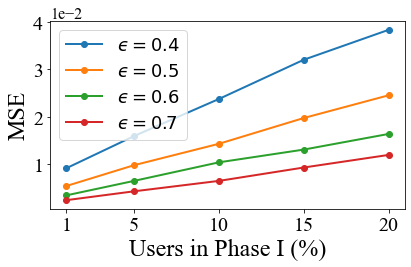

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.50), ('X2', 'X3', 0.50), ('X3', 'X4', 0.50)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [ 0.01, 0.05, 0.10, 0.15, 0.20]  # Phase I user fractions (m)
n = 5000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_5k__eps_phase1_corr_50_4attr.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_5k__eps_phase1_corr_50_4attr.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.500 (specified: 0.5)
Empirical P[X3 == X2]: 0.501 (specified: 0.5)
Empirical P[X4 == X3]: 0.500 (specified: 0.5)

Pearson correlations:
           X1        X2        X3        X4
X1  1.000000  0.444856  0.197085  0.088519
X2  0.444856  1.000000  0.446633  0.200423
X3  0.197085  0.446633  1.000000  0.445677
X4  0.088519  0.200423  0.445677  1.000000


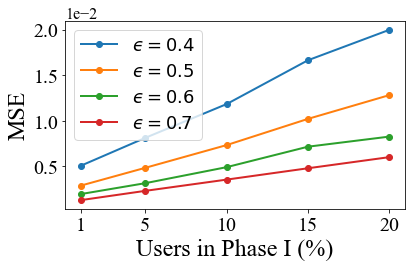

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.50), ('X2', 'X3', 0.50), ('X3', 'X4', 0.50)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [ 0.01, 0.05, 0.10, 0.15, 0.20]  # Phase I user fractions (m)
n = 10000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_10k__eps_phase1_corr_50_4attr.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_10k__eps_phase1_corr_50_4attr.svg', format='svg')

plt.show()


DATASET CORRELATION CHECKS:
Empirical P[X2 == X1]: 0.499 (specified: 0.5)
Empirical P[X3 == X2]: 0.496 (specified: 0.5)
Empirical P[X4 == X3]: 0.505 (specified: 0.5)

Pearson correlations:
           X1        X2        X3        X4
X1  1.000000  0.448363  0.195565  0.092555
X2  0.448363  1.000000  0.441347  0.194429
X3  0.195565  0.441347  1.000000  0.445180
X4  0.092555  0.194429  0.445180  1.000000


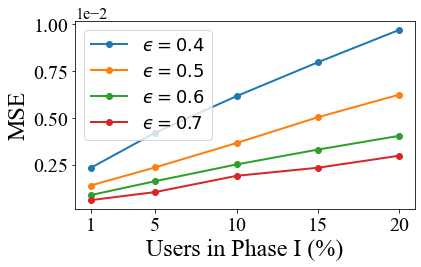

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(10))
correlations = [('X1', 'X2', 0.50), ('X2', 'X3', 0.50), ('X3', 'X4', 0.50)]
epsilons = [0.4, 0.5, 0.6, 0.7]
fractions = [ 0.01, 0.05, 0.10, 0.15, 0.20]  # Phase I user fractions (m)
n = 20000
R = 100  # number of independent runs

# --- Fixed seed for base dataset ---
seed = 42
df = correlated_data_generator(domain, n, correlations=correlations, seed=seed)
columns = df.columns.tolist()
print("DATASET CORRELATION CHECKS:")

# Print empirical pairwise equality probability
for i in range(len(columns) - 1):
    col1 = columns[i]
    col2 = columns[i + 1]
    specified = [c[2] for c in correlations if c[0] == col1 and c[1] == col2][0]
    equal_prob = np.mean(df[col1] == df[col2])
    print(f"Empirical P[{col2} == {col1}]: {equal_prob:.3f} (specified: {specified})")

print("\nPearson correlations:\n", df.corr())

# Precompute constants
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in columns}

# MSE storage: shape (len(epsilons), len(fractions), R)
all_mse_corrrr = np.zeros((len(epsilons), len(fractions), R))

# Evaluate Corr-RR for all eps and fractions
for r in range(R):
    for e_idx, eps in enumerate(epsilons):
        for f_idx, m in enumerate(fractions):
            phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=m)
            n_A = int(m * len(df))
            n_B = len(df_B)

            p_y_table = {
                (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
                for a in columns for b in columns if a != b
            }

            pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
            est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
            combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

            mse = np.mean([
                np.mean([
                    (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                    for v in domain_sorted
                ]) for col in columns
            ])
            all_mse_corrrr[e_idx, f_idx, r] = mse

# Average over runs
mean_mse = all_mse_corrrr.mean(axis=2)  # shape: (len(epsilons), len(fractions))

# --- Plot: x = % Phase I users, lines = different ε ---
plt.figure(figsize=(6, 4))

x_vals = [int(f * 100) for f in fractions]

for e_idx, eps in enumerate(epsilons):
    plt.plot(x_vals, mean_mse[e_idx, :],
             marker='o', linewidth=2, markersize=6,
             label=fr'$ ϵ= {eps}$')

plt.xlabel('Users in Phase I (%)', fontsize=24)
plt.ylabel('MSE', fontsize=24)
plt.xticks(x_vals, fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper left')
plt.tight_layout()

# Save results
results_df = pd.DataFrame({
    'fraction': x_vals
})
for e_idx, eps in enumerate(epsilons):
    results_df[f'ϵ={eps}'] = mean_mse[e_idx, :]

results_df.to_excel('C:\\Users\\ss6365\\Desktop\\sp_results\\excel\\mse_by_frac_20k__eps_phase1_corr_50_4attr.xlsx', index=False)
plt.savefig('C:\\Users\\ss6365\\Desktop\\sp_results\\plots\\mse_by_frac_20k__eps_phase1_corr_50_4attr.svg', format='svg')

plt.show()
